In [1]:
import jax
import jax.numpy as jnp

import json
import deepdish
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from flax_models.vgg import build_vgg16

In [2]:
!wget https://github.com/pytorch/hub/raw/master/images/dog.jpg
!wget https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json

In [3]:
model = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [4]:
jax_model, jax_params = build_vgg16(show_parameter_overview=True)

+---------------------------------+------------------+-------------+------+-----+
| Name                            | Shape            | Size        | Mean | Std |
+---------------------------------+------------------+-------------+------+-----+
| params/Dense_0/bias             | (4096,)          | 4,096       | 0.0  | 0.0 |
| params/Dense_0/kernel           | (25088, 4096)    | 102,760,448 | 0.0  | 0.0 |
| params/Dense_1/bias             | (4096,)          | 4,096       | 0.0  | 0.0 |
| params/Dense_1/kernel           | (4096, 4096)     | 16,777,216  | 0.0  | 0.0 |
| params/Dense_2/bias             | (1000,)          | 1,000       | 0.0  | 0.0 |
| params/Dense_2/kernel           | (4096, 1000)     | 4,096,000   | 0.0  | 0.0 |
| params/VGGBlock_0/Conv_0/bias   | (64,)            | 64          | 0.0  | 0.0 |
| params/VGGBlock_0/Conv_0/kernel | (3, 3, 3, 64)    | 1,728       | 0.0  | 0.0 |
| params/VGGBlock_0/Conv_1/bias   | (64,)            | 64          | 0.0  | 0.0 |
| params/VGGBloc

In [5]:
print([weight.name for weight in model.weights])

['block1_conv1/kernel:0', 'block1_conv1/bias:0', 'block1_conv2/kernel:0', 'block1_conv2/bias:0', 'block2_conv1/kernel:0', 'block2_conv1/bias:0', 'block2_conv2/kernel:0', 'block2_conv2/bias:0', 'block3_conv1/kernel:0', 'block3_conv1/bias:0', 'block3_conv2/kernel:0', 'block3_conv2/bias:0', 'block3_conv3/kernel:0', 'block3_conv3/bias:0', 'block4_conv1/kernel:0', 'block4_conv1/bias:0', 'block4_conv2/kernel:0', 'block4_conv2/bias:0', 'block4_conv3/kernel:0', 'block4_conv3/bias:0', 'block5_conv1/kernel:0', 'block5_conv1/bias:0', 'block5_conv2/kernel:0', 'block5_conv2/bias:0', 'block5_conv3/kernel:0', 'block5_conv3/bias:0', 'fc1/kernel:0', 'fc1/bias:0', 'fc2/kernel:0', 'fc2/bias:0', 'predictions/kernel:0', 'predictions/bias:0']


In [6]:
jax_params["params"].keys(), jax_params["params"]["VGGBlock_2"].keys(), jax_params["params"]["VGGBlock_0"]["Conv_0"].keys()

(frozen_dict_keys(['VGGBlock_0', 'VGGBlock_1', 'VGGBlock_2', 'VGGBlock_3', 'VGGBlock_4', 'Dense_0', 'Dense_1', 'Dense_2']),
 frozen_dict_keys(['Conv_0', 'Conv_1', 'Conv_2']),
 frozen_dict_keys(['kernel', 'bias']))

In [7]:
pre_trained_params_vgg16 = {
    "params": {
        "VGGBlock_0": {
            "Conv_0":  {
                "kernel": model.weights[0].numpy(),
                "bias": model.weights[1].numpy()
            },
            "Conv_1":  {
                "kernel": model.weights[2].numpy(),
                "bias": model.weights[3].numpy()
            },
        },
        "VGGBlock_1": {
            "Conv_0":  {
                "kernel": model.weights[4].numpy(),
                "bias": model.weights[5].numpy()
            },
            "Conv_1":  {
                "kernel": model.weights[6].numpy(),
                "bias": model.weights[7].numpy()
            },
        },
        "VGGBlock_2": {
            "Conv_0":  {
                "kernel": model.weights[8].numpy(),
                "bias": model.weights[9].numpy()
            },
            "Conv_1":  {
                "kernel": model.weights[10].numpy(),
                "bias": model.weights[11].numpy()
            },
            "Conv_2":  {
                "kernel": model.weights[12].numpy(),
                "bias": model.weights[13].numpy()
            },
        },
        "VGGBlock_3": {
            "Conv_0":  {
                "kernel": model.weights[14].numpy(),
                "bias": model.weights[15].numpy()
            },
            "Conv_1":  {
                "kernel": model.weights[16].numpy(),
                "bias": model.weights[17].numpy()
            },
            "Conv_2":  {
                "kernel": model.weights[18].numpy(),
                "bias": model.weights[19].numpy()
            },
        },
        "VGGBlock_4": {
            "Conv_0":  {
                "kernel": model.weights[20].numpy(),
                "bias": model.weights[21].numpy()
            },
            "Conv_1":  {
                "kernel": model.weights[22].numpy(),
                "bias": model.weights[23].numpy()
            },
            "Conv_2":  {
                "kernel": model.weights[24].numpy(),
                "bias": model.weights[25].numpy()
            },
        },
        "Dense_0":  {
            "kernel": model.weights[26].numpy(),
            "bias": model.weights[27].numpy()
        },
        "Dense_1":  {
            "kernel": model.weights[28].numpy(),
            "bias": model.weights[29].numpy()
        },
        "Dense_2":  {
            "kernel": model.weights[30].numpy(),
            "bias": model.weights[31].numpy()
        },
    }
}

deepdish.io.save(
    "vgg16_keras_imagenet.h5",
    pre_trained_params_vgg16
)

In [8]:
pre_trained_params_vgg16 = deepdish.io.load("vgg16_keras_imagenet.h5")

In [9]:
def predict_tf(model, prepocessing_fn, image_file):
    image = Image.open(image_file)

    plt.imshow(image)
    plt.show()

    image = image.resize((224, 224))
    x = tf.keras.preprocessing.image.img_to_array(image)
    x = prepocessing_fn(x)
    x = tf.expand_dims(x, axis=0)

    out = model.predict(x)
    top5_probs, top5_classes = jax.lax.top_k(out, k=5)
    top5_probs = jnp.squeeze(top5_probs, axis=0)
    top5_classes = jnp.squeeze(top5_classes, axis=0)

    labels = json.load(open('imagenet-simple-labels.json'))
    for i in range(top5_classes.shape[0]):
        print(labels[top5_classes[i]], top5_probs[i])

In [10]:
def predict_jax(model, params, prepocessing_fn, image_file):
    image = Image.open(image_file)

    plt.imshow(image)
    plt.show()

    image = image.resize((224, 224))
    x = tf.keras.preprocessing.image.img_to_array(image)
    x = prepocessing_fn(x)
    x = jnp.expand_dims(x, axis=0)

    out = model.apply(params, x)
    top5_probs, top5_classes = jax.lax.top_k(out, k=5)
    top5_probs = jnp.squeeze(top5_probs, axis=0)
    top5_classes = jnp.squeeze(top5_classes, axis=0)

    labels = json.load(open('imagenet-simple-labels.json'))
    for i in range(top5_classes.shape[0]):
        print(labels[top5_classes[i]], top5_probs[i])

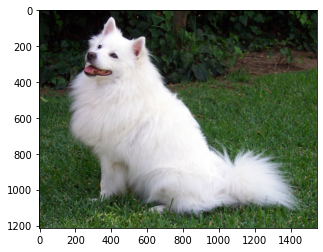

Samoyed 0.8227487
husky 0.062238593
Alaskan tundra wolf 0.025660891
Siberian Husky 0.011343671
collie 0.009979509


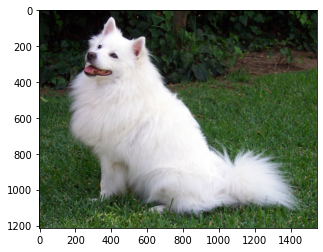

Samoyed 0.8229477
husky 0.062175505
Alaskan tundra wolf 0.02563637
Siberian Husky 0.0113315135
collie 0.009966835


In [12]:
predict_tf(
    model,
    tf.keras.applications.vgg16.preprocess_input,
    'dog.jpg'
)

predict_jax(
    jax_model,
    pre_trained_params_vgg16,
    tf.keras.applications.vgg19.preprocess_input,
    'dog.jpg'
)